<a href="https://colab.research.google.com/github/FriddeFrid91/vgs-ML/blob/main/video_game_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Game Dataset

We want to predict what video game genre will sell the best the following year by uing Random Forest Classification.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

url = "https://raw.githubusercontent.com/FriddeFrid91/vgs-ML/main/vgsales.csv"
df = pd.read_csv(url)
df.head()


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


# Inspecting The Dataset

In [51]:
# Looking at the datasets we see that there is 11 features and 16 597 rows. Both numeric and objects.
df.info()
len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


16598

In [52]:
# Looking at standard deviation.
df.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [53]:
# Looking for null values.
result = df.isna().sum()
print(result)

missing_values_year = df['Year'].isna().sum()
print("Missing values for 'Year': ", missing_values_year)

missing_values_publisher = df['Publisher'].isna().sum()
print("Missing values for 'Publisher'", missing_values_publisher)

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64
Missing values for 'Year':  271
Missing values for 'Publisher' 58


In [54]:
df.corr(numeric_only=True)
# There is a high correlation between EU_Sales and Global_Sales with 0.902.
# NA_Sales have the highest correlation with Global_Sales 0.941.
# JP_Sales and Global_Sales is lower with 0.611.
# It indicates that the Japanese market got a different taste in games then globally.
# Other sales could mean other continents such as Africa, South America, Asia (Excluding Japan because it has it's own feature) and Australia/Oceania.

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,1.000000,0.178814,-0.401362,-0.379123,-0.267785,-0.332986,-0.427407
Year,0.178814,1.000000,-0.091402,0.006014,-0.169316,0.041058,-0.074735
NA_Sales,-0.401362,-0.091402,1.000000,0.767727,0.449787,0.634737,0.941047
EU_Sales,-0.379123,0.006014,0.767727,1.000000,0.435584,0.726385,0.902836
JP_Sales,-0.267785,-0.169316,0.449787,0.435584,1.000000,0.290186,0.611816
Other_Sales,-0.332986,0.041058,0.634737,0.726385,0.290186,1.000000,0.748331
Global_Sales,-0.427407,-0.074735,0.941047,0.902836,0.611816,0.748331,1.000000


In [55]:
# An overlook at which genre dominates the dataset.
df['Genre'].value_counts()


,count
Genre,
Action,3316
Sports,2346
Misc,1739
Role-Playing,1488
Shooter,1310
Adventure,1286
Racing,1249
Platform,886
Simulation,867


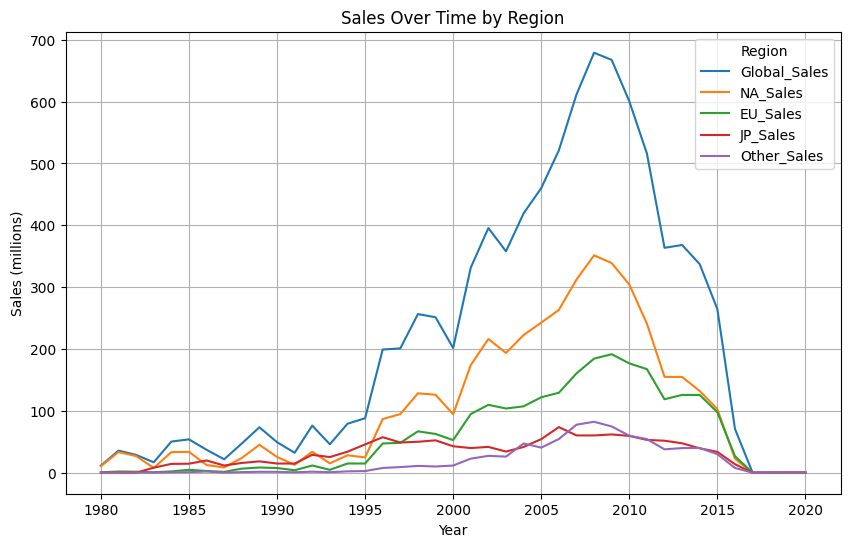

Best sales: 678.90
Best year:  2008.0


In [56]:
import matplotlib.pyplot as plt

# Group after year and summarize the total sales in every region for each year.
region_sales = df.groupby('Year')[['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# We want the columns as lines.
region_sales.plot(kind='line', figsize=(10,6))

plt.title('Sales Over Time by Region')
plt.xlabel('Year')
plt.ylabel('Sales (millions)')
plt.legend(title='Region')
plt.grid(True)
plt.show()

sales_per_year = df.groupby('Year')['Global_Sales'].sum()
best_sales = sales_per_year.max()
best_year = sales_per_year.idxmax()
print(f"Best sales: {best_sales:.2f}")
print('Best year: ', best_year)

# We can see in the piture below that video game sales peaked at 2008.


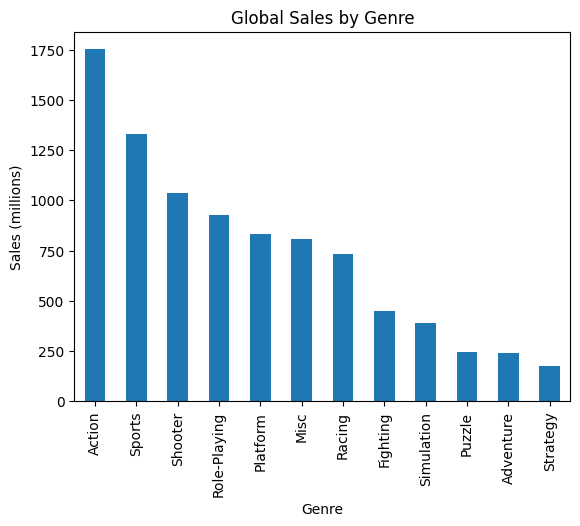

In [57]:
genre_sales = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
genre_sales.plot(kind='bar')
plt.title('Global Sales by Genre')
plt.ylabel('Sales (millions)')
plt.show()


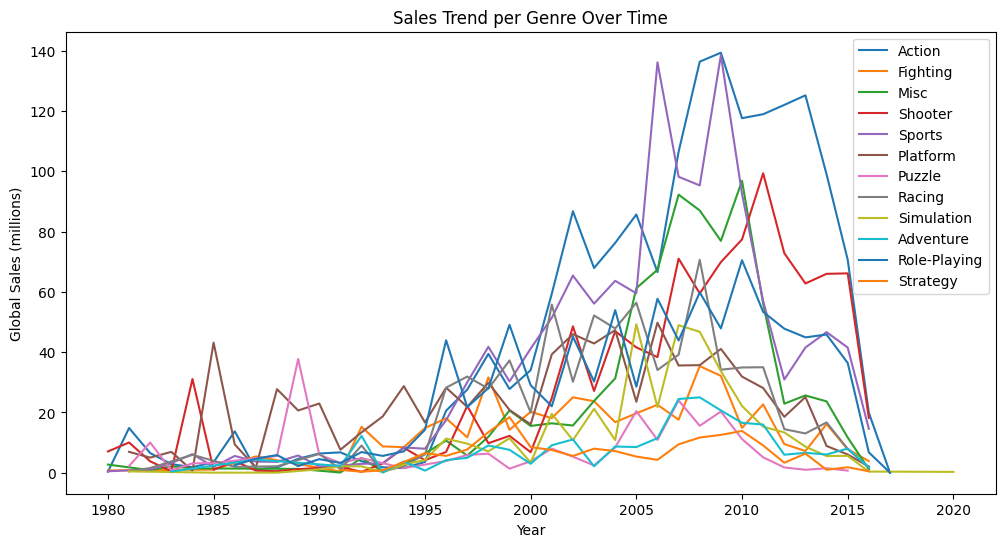

In [58]:
genre_trend = df.groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for genre in genre_trend['Genre'].unique():
    data = genre_trend[genre_trend['Genre'] == genre]
    plt.plot(data['Year'], data['Global_Sales'], label=genre)

plt.legend()
plt.title('Sales Trend per Genre Over Time')
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.show()


In [59]:
# PCA

Action, Sports, Misc & Role-Playing are pretty even in amount.

In [60]:
# Some differences in ammount of genres in the dataset.
amount_of_genres = df.groupby('Genre')['Name'].nunique().sort_values(ascending=False)
print(amount_of_genres)

Genre
Action          1925
Sports          1379
Misc            1327
Role-Playing    1219
Adventure       1048
Shooter          817
Racing           772
Simulation       726
Fighting         612
Platform         589
Strategy         584
Puzzle           499
Name: Name, dtype: int64


# Data Cleaning And Preprocessing

A concern is that we doesn't have enough features for the dataset.

In [68]:
# Drop all null values. All the columns that contatins null values are dropped.
df.dropna(axis=0)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


## Split up in X and Y

In [67]:
X = df.drop(['Genre', 'Name', 'Platform', 'Publisher', 'Year', 'Rank'], axis=1)
y = df['Genre']

# PCA

Our dataset only has 11 features. PCA is used to reduce the number of features so in this case it seems a bit excessive. But we can visualize our data using PCA.

In [63]:
# We use standard scaler to scale the features so the big values in the dataset won't dominate the smaller values.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled[:2])

[[50.48050838 57.13692978 11.93805759 44.60608534 52.86402505]
 [35.28443669  6.7941883  21.76729621  3.82822442 25.53250298]]


[[ 9.65158111e+01  2.14632495e-01]
 [ 4.80539419e+01  9.80792583e+00]
 [ 4.07906948e+01 -2.52354082e+00]
 ...
 [-6.14652747e-01  3.38790805e-03]
 [-6.12148113e-01 -1.06526034e-03]
 [-6.10350235e-01  1.10052514e-02]]


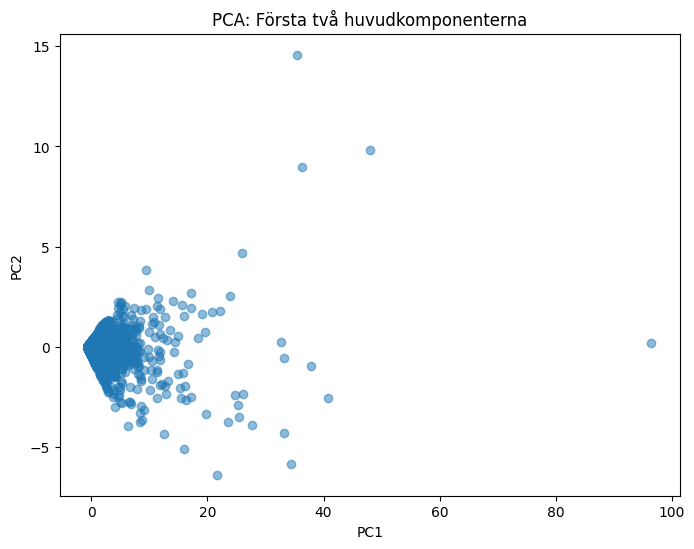

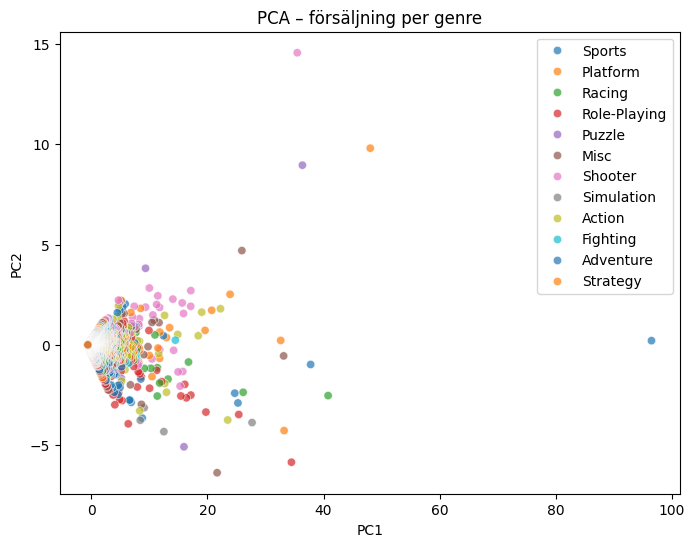

In [64]:
X_clean = X.dropna()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clean)
print(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title("PCA: Första två huvudkomponenterna")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df["Genre"],
    palette="tab10",
    alpha=0.7
)
plt.title("PCA – försäljning per genre")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


# Feature Engineering

In [65]:
region_sales = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().sort_values('NA_Sales', ascending=False)
print(region_sales)


              NA_Sales  EU_Sales  JP_Sales  Other_Sales
Genre                                                  
Action          877.83    525.00    159.95       187.38
Sports          683.35    376.85    135.37       134.97
Shooter         582.60    313.27     38.28       102.69
Platform        447.05    201.63    130.77        51.59
Misc            410.24    215.98    107.76        75.32
Racing          359.42    238.39     56.69        77.27
Role-Playing    327.28    188.06    352.31        59.61
Fighting        223.59    101.32     87.35        36.68
Simulation      183.31    113.38     63.70        31.52
Puzzle          123.78     50.78     57.31        12.55
Adventure       105.80     64.13     52.07        16.81
Strategy         68.70     45.34     49.46        11.36


In [66]:
target = 'Global_Sales'
X = df.drop(columns=['Genre'])
y = df[target]

# Split up the data set in Training, Test and Validation

# Train The Random Forest Classification Model

# Evaluate

# Fine Tune The Model